In [1]:
import sys
import os
import pandas as pd
sys.path.append('../../../py_pkg')
import platform_designer as qpd
import pd_ip.pd_ip as pd_ip
from pd_ip.custom_ips import niosv_aes
import pd_ip.quartus_ips as quartus_ips
from analysis import tunable_tdc_sweeper as tts
import time

In [2]:
# import Quartus Platform Designer system as instance objects
sopcinfo_header = os.path.abspath("../../../../EXPERIMENTS/quartus_projects/niosv_aes/qsys_headers/hps_0.h")
pd_0 = qpd.pd_system("u0", [sopcinfo_header], 0xC0000000, "/dev/mem")
# initialize all modules and setup MMIO
pd_0.initialize(True)

Imported from /root/PL-Sensor-Intel/EXPERIMENTS/quartus_projects/niosv_aes/qsys_headers/hps_0.h
COMPONENT_NAME: DMA_to_SDRAM
	CSR_COMPONENT_TYPE : altera_msgdma
	COMPONENT_TYPE : altera_msgdma
	CSR_COMPONENT_NAME : DMA_to_SDRAM
	CSR_BASE : 64
	CSR_SPAN : 32
	CSR_END : 95
	CSR_IRQ : 1
	CSR_BURST_ENABLE : 1
	CSR_BURST_WRAPPING_SUPPORT : 1
	CSR_CHANNEL_ENABLE : 0
	CSR_CHANNEL_ENABLE_DERIVED : 0
	CSR_CHANNEL_WIDTH : 8
	CSR_DATA_FIFO_DEPTH : 2048
	CSR_DATA_WIDTH : 256
	CSR_DESCRIPTOR_FIFO_DEPTH : 32
	CSR_DMA_MODE : 2
	CSR_ENHANCED_FEATURES : 0
	CSR_ERROR_ENABLE : 0
	CSR_ERROR_ENABLE_DERIVED : 0
	CSR_ERROR_WIDTH : 8
	CSR_MAX_BURST_COUNT : 8
	CSR_MAX_BYTE : 65536
	CSR_MAX_STRIDE : 1
	CSR_PACKET_ENABLE : 0
	CSR_PACKET_ENABLE_DERIVED : 0
	CSR_PREFETCHER_ENABLE : 0
	CSR_PROGRAMMABLE_BURST_ENABLE : 0
	CSR_RESPONSE_PORT : 2
	CSR_STRIDE_ENABLE : 0
	CSR_STRIDE_ENABLE_DERIVED : 0
	CSR_TRANSFER_TYPE : Full Word Accesses Only
	DESCRIPTOR_SLAVE_COMPONENT_TYPE : altera_msgdma
	DESCRIPTOR_SLAVE_COMPONENT_

In [3]:
# setup DMA *TODO* convert to python module - currently a C driver
dma = os.open("/dev/msgdma_tdc", os.O_RDONLY)
pd_0.pd_ip_insts["DMA_to_SDRAM"].dma_fh=dma

In [4]:
# Connect reset PIOs to proper instances
pd_0.pd_ip_insts["theta_pll_reconfig"].reset_pio = pd_0.pd_ip_insts["theta_pll_reset_pio"]
pd_0.pd_ip_insts["phi_pll_reconfig"].reset_pio = pd_0.pd_ip_insts["phi_pll_reset_pio"]
pd_0.pd_ip_insts["pulsegenerator"].reset_pio = pd_0.pd_ip_insts["tdc_reset_pio"]
# Connect locked PIOs to PLLs
pd_0.pd_ip_insts["theta_pll_reconfig"].locked_pio = pd_0.pd_ip_insts["theta_locked"]
pd_0.pd_ip_insts["phi_pll_reconfig"].locked_pio = pd_0.pd_ip_insts["phi_locked"]
# Configure PLL number of outputs
pd_0.pd_ip_insts["theta_pll_reconfig"].num_out = 2
pd_0.pd_ip_insts["phi_pll_reconfig"].num_out = 1

In [5]:
# Import PLL configs for sweep
theta_pll_configs = "../pll_configs/theta.csv"
theta_cfg_params = pd.read_csv(theta_pll_configs)
phi_pll_configs   = "../pll_configs/phi.csv"
phi_cfg_params = pd.read_csv(phi_pll_configs)

In [6]:
# Hold pulsegenerator and TDC in reset until PLL is configured
pd_0.pd_ip_insts["pulsegenerator"].hold_reset()

# Hold PLL theta in reset until after phi is reset
pd_0.pd_ip_insts["theta_pll_reconfig"].hold_reset()

# # Initialize phi clock - Mostly to ensure bandwidth setting is correct
pd_0.pd_ip_insts["phi_pll_reconfig"].update_all_50(32, 1, [32], "low", 1, [{"phase_updn":0, "phase_amt":0}])

# # Hold PLL theta in reset until after phi is reset
pd_0.pd_ip_insts["theta_pll_reconfig"].reset_pll()
pd_0.pd_ip_insts["pulsegenerator"].reset()

In [7]:
# AES has no direct interface, so create an instance manually
niosv_aes_ip_dict = {
    "COMPONENT_NAME" : "niosv_aes",
    "COMPONENT_TYPE" : "niosv_aes",
    "BASE" : 0x000,
    "SPAN" : 0x000,
    "END"  : 0x000
}
pd_0.pd_ip_insts["niosv_aes"] = niosv_aes.niosv_aes(
    ip_dict=niosv_aes_ip_dict, mmio_init=False, periph_mem=pd_0.pd_ip_insts["peripheral_mem"])

# All AES traffic flows through IP-Sync instance, so copy it's MMIO interface
pd_0.pd_ip_insts["ip_sync_niosv"].copy_mmio_ifc(pd_0.pd_ip_insts["niosv_aes"])

# Reset AES
pd_0.pd_ip_insts["niosv_aes"].hold_reset()

# Check AES decrypt
pd_0.pd_ip_insts["niosv_aes"].pre()
pd_0.pd_ip_insts["niosv_aes"].run()
pd_0.pd_ip_insts["niosv_aes"].post()

# Hold SEC Works AES in reset during Theta sweep
pd_0.pd_ip_insts["niosv_aes"].hold_reset()

In [8]:
# Construct a tdc_sweeper instance
tdc_sweeper = tts.TunableTDCSweeper(
    pd_0.pd_ip_insts["theta_pll_reconfig"], 
    pd_0.pd_ip_insts["phi_pll_reconfig"], 
    pd_0.pd_ip_insts["pulsegenerator"], 
    pd_0.pd_ip_insts["DMA_to_SDRAM"], 
    tdc_len = 128,
    target_ip=pd_0.pd_ip_insts["niosv_aes"])

In [18]:
# Sweep theta, collect plot results
# Specify theta sweepe parameters
theta_sweep_params = {
    "delay_lower_bound" : 2300,
    "delay_upper_bound" : 4500,
    "min var prop dist" : 28,
    "max var prop dist" : 36,
    "target rising mu"  : 32
}
time_now = time.strftime("%Y-%m-%d_%H:%M:%S", time.gmtime())
out_fh = f"../../../archived_results/data/niosv_theta_sweep_{time_now}.csv"
# Start theta sweep
tdc_sweeper.sweep_theta(
    theta_cfg_params=theta_cfg_params, 
    theta_samples=2**12, 
    sweep_params=theta_sweep_params, 
    tune_param="mid", 
    sweep_data_fh=out_fh, 
    debug=0)

100% (320 of 320) |######################| Elapsed Time: 0:01:14 Time:  0:01:14


<Figure size 1920x1440 with 0 Axes>

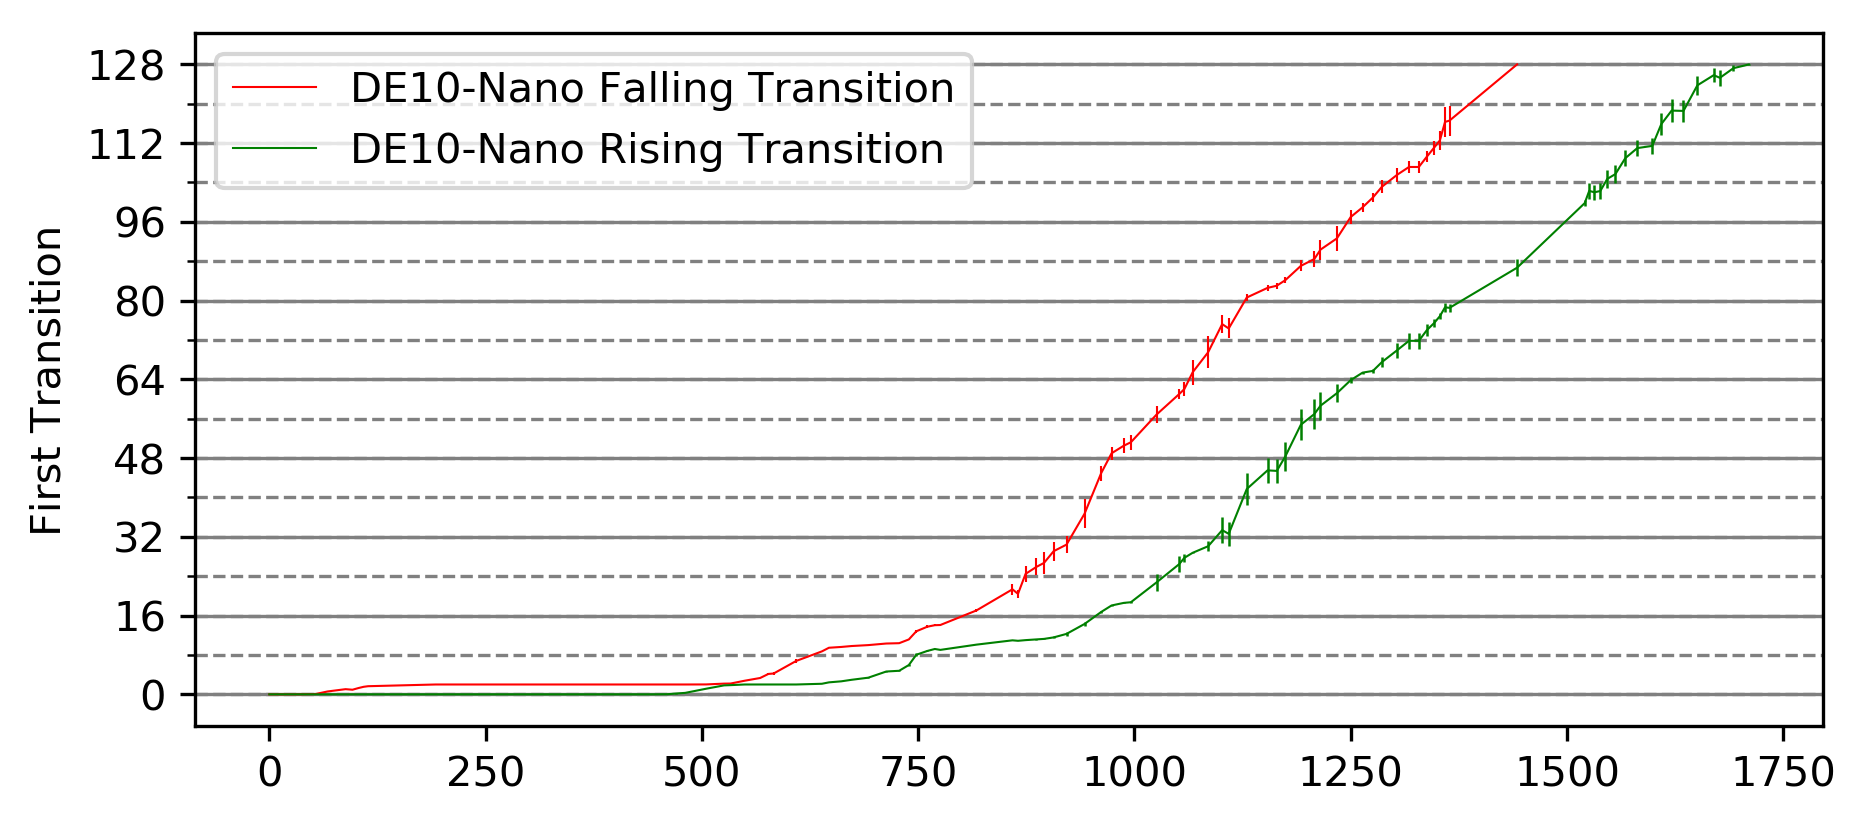

<Figure size 1920x1440 with 0 Axes>

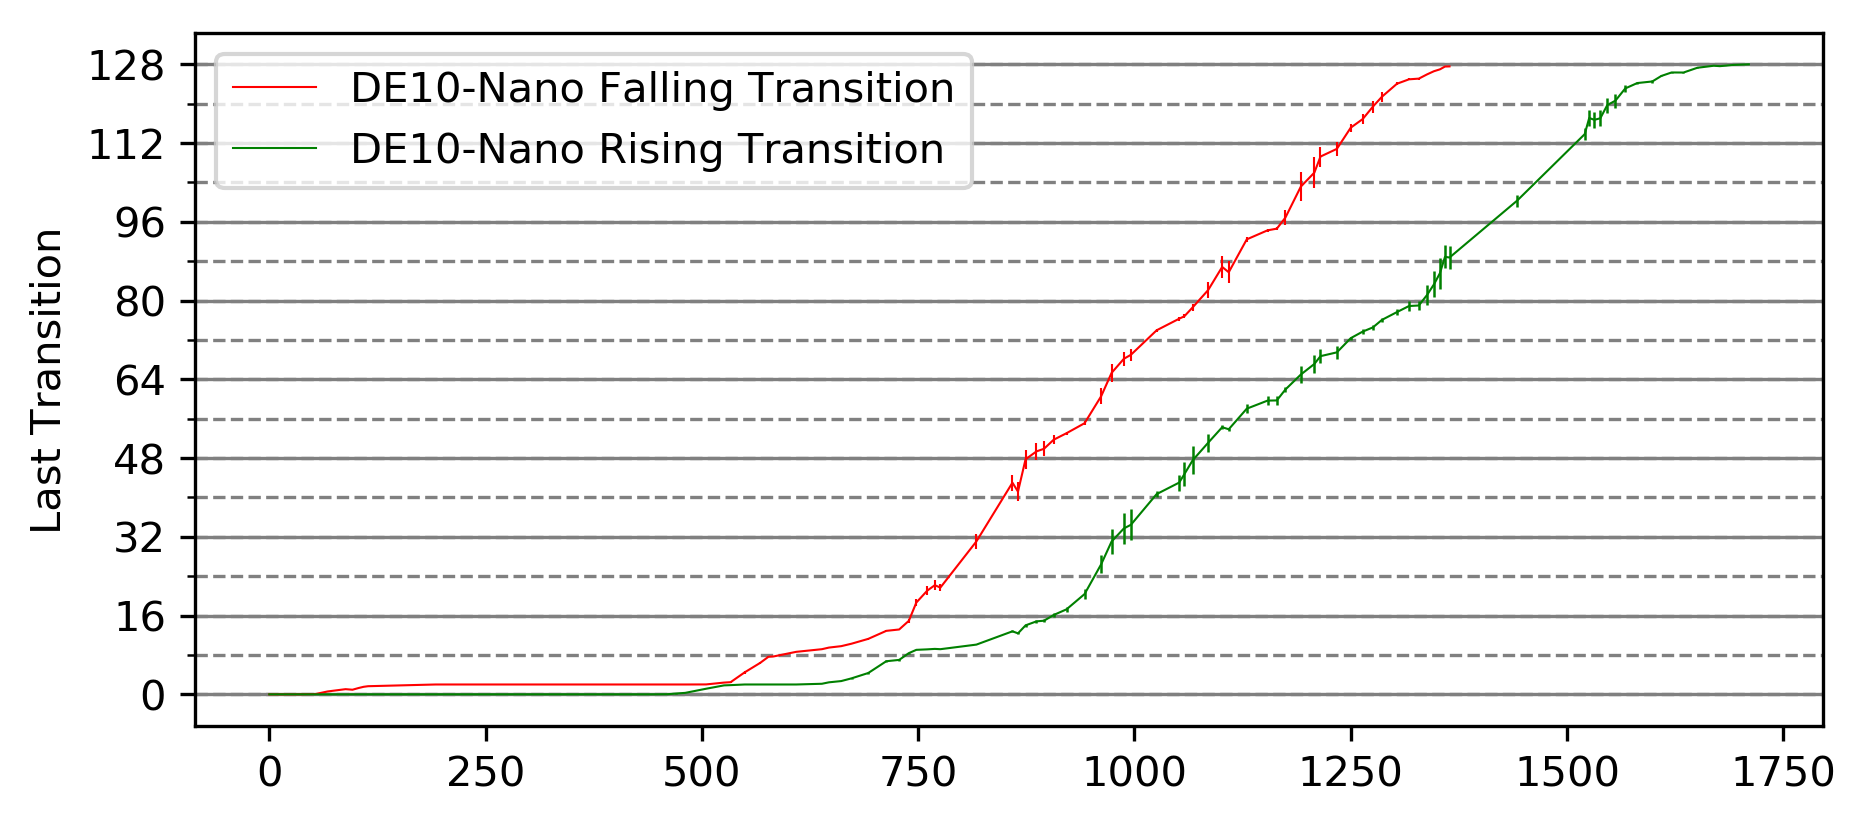

<Figure size 1920x1440 with 0 Axes>

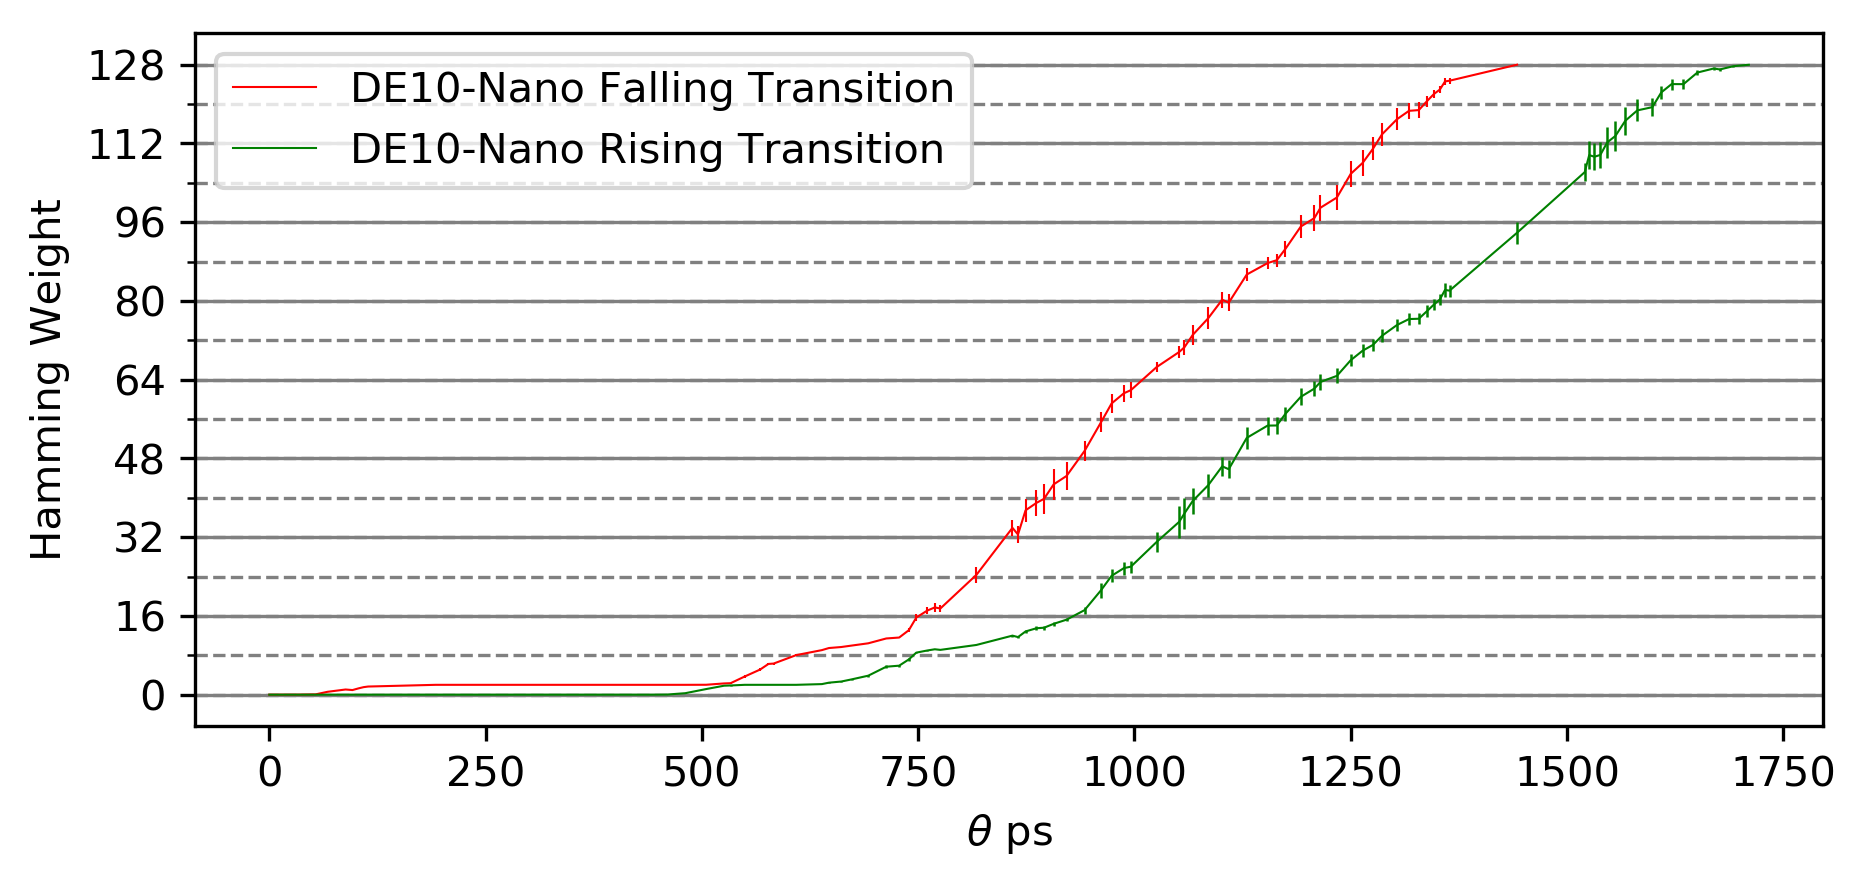

<Figure size 1920x1440 with 0 Axes>

In [19]:
# Plot theta sweep results
tdc_sweeper.plot_theta_sweep_results(out_fh)

In [20]:
# Phi sweep

# Specify fast theta tune parameters
theta_sweep_params = {
    "delay_lower_bound" : 2100,
    "delay_upper_bound" : 3900,
    "min var prop dist" : 28,
    "max var prop dist" : 36,
    "target rising mu"  : 32
}

# Start fast theta sweep
tdc_sweeper.pop_tune_theta(
    theta_cfg_params=theta_cfg_params,
    theta_samples=2**14, 
    sweep_params=theta_sweep_params,
    tune_rise=True,
    tuning_param="mid")

print(tdc_sweeper.tuned_theta_avg_rise)
print(tdc_sweeper.tuned_theta_avg_fall)

time_now = time.strftime("%Y-%m-%d_%H:%M:%S", time.gmtime())
out_fh = f"../../../archived_results/data/niosv_phi_sweep_{time_now}.csv"

# Sweep phi, collect results
tdc_sweeper.sweep_phi(
    phi_cfg_params=phi_cfg_params,
    theta_samples=2**12, 
    sweep_data_fh=out_fh)

100% (320 of 320) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (1 of 10368) |                      | Elapsed Time: 0:00:00 ETA:   0:18:05

Theta tuning complete! mid=64.322265625
	          M:12
	          N:1
	          C:6
	Phase Bumps:31
	 Delay (ps):3541.6670000000013
64.322265625
99.719482421875


100% (10368 of 10368) |##################| Elapsed Time: 0:17:11 Time:  0:17:11


In [ ]:
# Plot phi sweep results
tdc_sweeper.plot_phi_sweep_results(out_fh)